# QYNAPSE - MACHINE LEARNING TECHNICAL TEST


### Objective

This test aims to evaluate your skills in data science, machine learning, and programming. Your analytical mindset, your initiative and your creativity will also be appreciated though this exercise.

We will take into consideration:
- your statistical analysis skills
- your machine learning methodology
- your ability to present and interpret your results
- the quality and intelligibility of your code
- your suggestions for further improvements


You will be asked to complete some cells in this notebook, wherever you read "# ENTER YOUR CODE HERE". You will also be asked formal questions **<font color=green>in green</font>**, to which you will answer (briefly) in the following cell, either in Markdown or in comments.


***
### Exercise

The file "data.csv" provides data from patients diagnosed with Alzheimer's disease (AD) or a prodromal stage of the disease called Mild Cognitive Impairment (MCI). The data consist of demographic data (age, gender, marital status, years of education), clinical data (cognitive scores), data extracted from Magnetic Resonance Imaging (MRI), data extracted from Cerebro-Spinal Fluid (CSF) analysis, and genetic data.

The patients are identified with a unique id called RID. Each patient has two sets of data, one corresponding to baseline (i.e. at M = 0 months) and one corresponding to a second visit at M = 24 months.

A description of the data is available in the file "data_dict.csv".

We want to predict two outcomes :
- **whether the MCI patients are going to convert towards AD within 24 months.** In other words, we want to predict the value of the DX variable at M=24 for patients that have DX='MCI' at M=0. 
- **the evolution of the cognitive score ADAS11 within 24 months for all patients.** In other words, we want to predict the value of the ADAS11 variable at M=24 for all patients.

To do so, we will proceed as such for each task :
- explore the data
- choose the metrics we will use to evaluate models performances
- choose **2 models of different nature** for the prediction 
- train and optimize these 2 models
- select the best model between the two

For both tasks, only the data from baseline (i.e. M=0) can be used as inputs to your models.


### Libraries import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import here the libraries and objects you need

from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

### Data loading

In [2]:
data = pd.read_csv('data.csv')

### Data meaning

In [3]:
display(pd.read_csv('data_dict.csv'))

,Name,Description,Source
0,RID,Unique identifier of the patient,-
1,M,Months after baseline visit,-
2,MMSE,MMSE score (0-30),CLINICAL
3,ADAS11,ADAS11 score,CLINICAL
4,PTEDUCAT,Years of education,DEMO
5,PTGENDER,"Gender. 0 = Male, 1 = Female",DEMO
6,AGE,Age,DEMO
7,PTMARRY,"Marital status. 0 = Married, 1=Widowed, 2=Divo...",DEMO
8,APOE4,"Number of APOE4 alleles (0,1 or 2)",GENETIC
9,DX,Diagnosis at the time of the visit. NL (Normal...,CLINICAL


## 1 - Descriptive statistics

**<font color=green>Considering the age and sex of patients at M=0, which statistical procedure would allow you to assess whether or not the distributions in age and sex of the MCI and AD patients are identical ? Illustrate your answer with a few relevant graphs.</font>**


Since *Sex* is a categorical Data, it doesn't make sense to use histogram or kernel density estimation on it. However, to have an overview of the data, a bar-plot of patients' sex at M=0 is plotted depending of the diagnosis. Being a categorical data, the only statistic that can be used is the proportion of M and F for each diagnosis. This difference being relevant enough, one can consider that the distribution of sex of the MCI and AD patients are not identical, even if they are close. It means that the random variables *Sex* and *DX* are not independant

For *Age*, a kernel density estimation (with gaussian kernel) is plotted. It is prefered over a displot because it's easier to read for two curves. From the graph, it appears that the curve cleary differ, and one can state that the distribution in age of the MCI and AD patients are not identical. It means that the random variable *Age* and *DX* are not independant

**Code :**

Proportion of M for AD : 0.5 %
Proportion of M for MCI : 0.39 %
Proportion of F for AD : 0.5 %
Proportion of F for MCI : 0.61 %
Distributions in sex for the MCI and AD patients are not identical


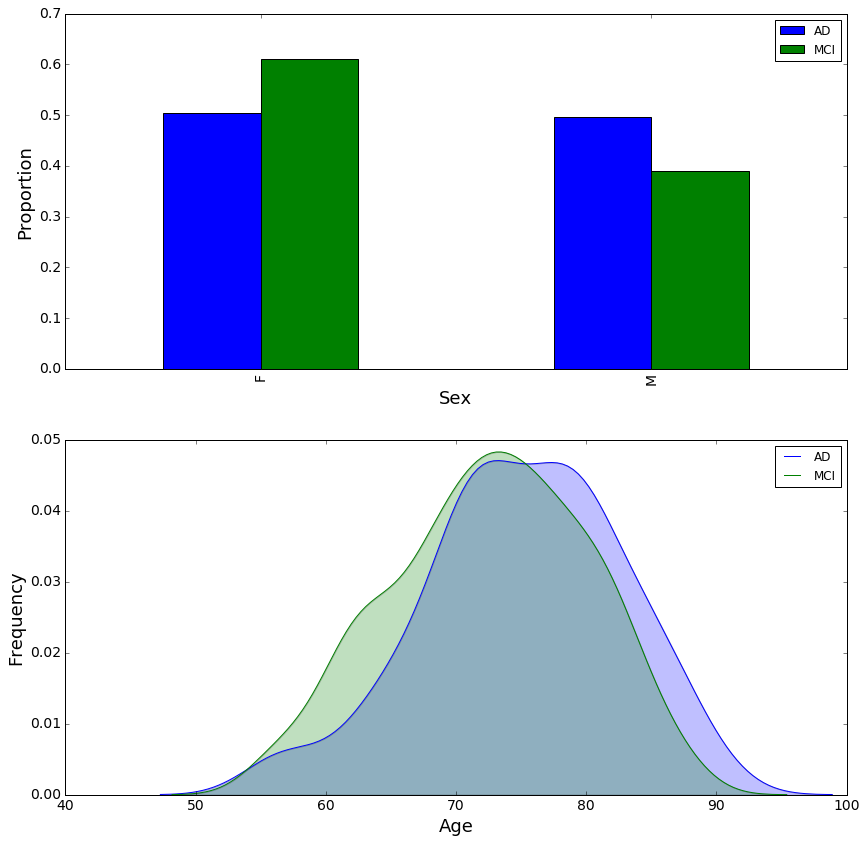

In [4]:
"""Substract data of interest"""
df_sub = data[["AGE","PTGENDER","DX","M"]]
#df_M0 is the dataframe for  M = 0
df_M0 = df_sub.loc[df_sub["M"] == 0]
df_M0 = df_M0.drop(labels = "M",axis = 1)

f,ax=plt.subplots(2,1,figsize=(14,14))

"""Plot Sex barplot depending on Diagnosis"""
#group dataframe depending on gender, counting the number of each gender bellonging to each diagnosis
df_gender = df_M0.groupby('DX').PTGENDER
#To have a better data visualization, the barplot will not represent each sex count, but each proportion
full_arr = np.array([[0.,0.],[0.,0.]])
full_label = np.array(["aaa","aaa"])
i = 0
for label, arr in df_gender:
    L = 1.0*len(arr)
    M,F = sum(arr)/L, 1 - sum(arr/L)
    full_arr[i,:] = [M,F]
    full_label[i] = label
    i += 1

df_gender = pd.DataFrame(data= {"M": full_arr[:,0],"F" : full_arr[:,1]},index=full_label)
df_gender.transpose().plot(kind="bar",ax = ax[0])


"""Plot Age distribution depending on Diagnosis"""
#group dataframe depending on age
df_age = df_M0.groupby('DX').AGE

for label, arr in df_age:
    sns.kdeplot(arr, label=label, shade=True,ax=ax[1])

i = 0
for sub_ax in ax: 
    if i == 0:
        sub_ax.set_xlabel("Sex",fontsize = 18)
        sub_ax.set_ylabel("Proportion",fontsize=18)
    else:
        sub_ax.set_xlabel("Age",fontsize = 18)
        sub_ax.set_ylabel("Frequency",fontsize=18)
    i += 1
    sub_ax.xaxis.set_tick_params(labelsize=14)
    sub_ax.yaxis.set_tick_params(labelsize=14)  
    
print("Proportion of M for AD : {} %".format(full_arr[0,0].round(2)))
print("Proportion of M for MCI : {} %".format(full_arr[1,0].round(2)))
print("Proportion of F for AD : {} %".format(full_arr[0,1].round(2)))
print("Proportion of F for MCI : {} %".format(full_arr[1,1].round(2)))
print("Distributions in sex for the MCI and AD patients are not identical")

## 2 - Prediction of conversion towards AD

In this section, you shall only consider MCI patients at baseline, i.e. patients that have DX='MCI' at M=0. Remember that only the data from baseline (i.e. M=0) can be used as inputs to your models.

### Exploratory data analysis

**<font color=green>Which features seem to have an impact on the DX variable at M=24 ? Describe your methodological choices and illustrate your answer with a few relevant graphs.</font>** 


For the following question, I will use several markdown and code blocks to make the answer clearer


To assess the impact of each feature, I'll use __XGBOOST__ method. But before, data need to be cleaned a bit. Indeed, some values are NaN values. For PTMARRY for exemple, there are 10 NaN data. Because it's a categorical feature, they'll be replaced by the mode of other values.

For the study, only patients that go twice to see the doctor are relevant. That is to say, every patient that go only once to the doctor are discarded from the dataset


In [5]:
data = pd.read_csv('data.csv')

"""NaN values for PTMARRY are replaced by mode"""

index = data['PTMARRY'].index[data['PTMARRY'].apply(np.isnan)]
data.loc[index,"PTMARRY"] = data['PTMARRY'].mode()[0] + np.zeros(len(index))

"""For WholeBrain and ST29SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16 and other NaN is replaced by mean"""
index = data['WholeBrain'].index[data['WholeBrain'].apply(np.isnan)]
data.loc[index,'WholeBrain'] = data['WholeBrain'].mean() + np.zeros(len(index))
shortnames = ['ST29SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16','ST89SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16',
             'ST12SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16','ST71SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16']
for s in shortnames:
    index = data[s].index[data[s].apply(np.isnan)]
    data.loc[index,s] = data[s].mean() + np.zeros(len(index))


"""Let's clean the dataset of every patients that didn't go to 2 appointments, it will be usefull for now and later on"""
data_sub = pd.DataFrame(data["RID"])
data_sub["COUNT"] = 1
data_sub = data_sub.groupby("RID").sum()
"""Take RID of each patient that didn't go twice to the medecin"""
RID_to_purge = data_sub.loc[data_sub["COUNT"] != 2].index
"""Remove the not desired values
For this and the other problem, patients that didn't go twice to the medecin are not relevant and can be discarded"""
data = data[~data.RID.isin(RID_to_purge)]

"""Sort the data depending on RID to make dataframe clearer"""
data = data.sort_values("RID",ascending=True)

Select input fo perform __feature selection__

In [6]:
"""Input data : M = 0 , DX = MCI"""

"""Select the M = 0, DX = MCI, and the corresponding RID"""
X_feature_selection = data.loc[(data["M"] == 0) & (data["DX"] == "MCI")]
RID_classif = X_feature_selection.RID

X_feature_selection = X_feature_selection.drop(labels=["DX","M","RID"],axis=1)

"""From data, select the RID that correspond to the baseline"""
T = data[data.RID.isin(RID_classif)]
"""Select the corresponding M = 24"""
Y_feature_selection = T.loc[T["M"] == 24]
y_feature_selection_str = Y_feature_selection.DX.values
"""Convert y_feature_selection_str to int : 1 - AD, 0 - MCI"""
y_feature_selection = [1 if y == "AD" else 0 for y in y_feature_selection_str]
y_feature_selection = np.array(y_feature_selection)

First is plotted the __ kde distribution__ for each feature, depending on the *DX* label at M=24. This is done to have a better understanding of the data, but won't be used as a proof to state which data are the most important

/home/lucsoret/Logiciels/anaconda3/envs/tensorflow/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/home/lucsoret/Logiciels/anaconda3/envs/tensorflow/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


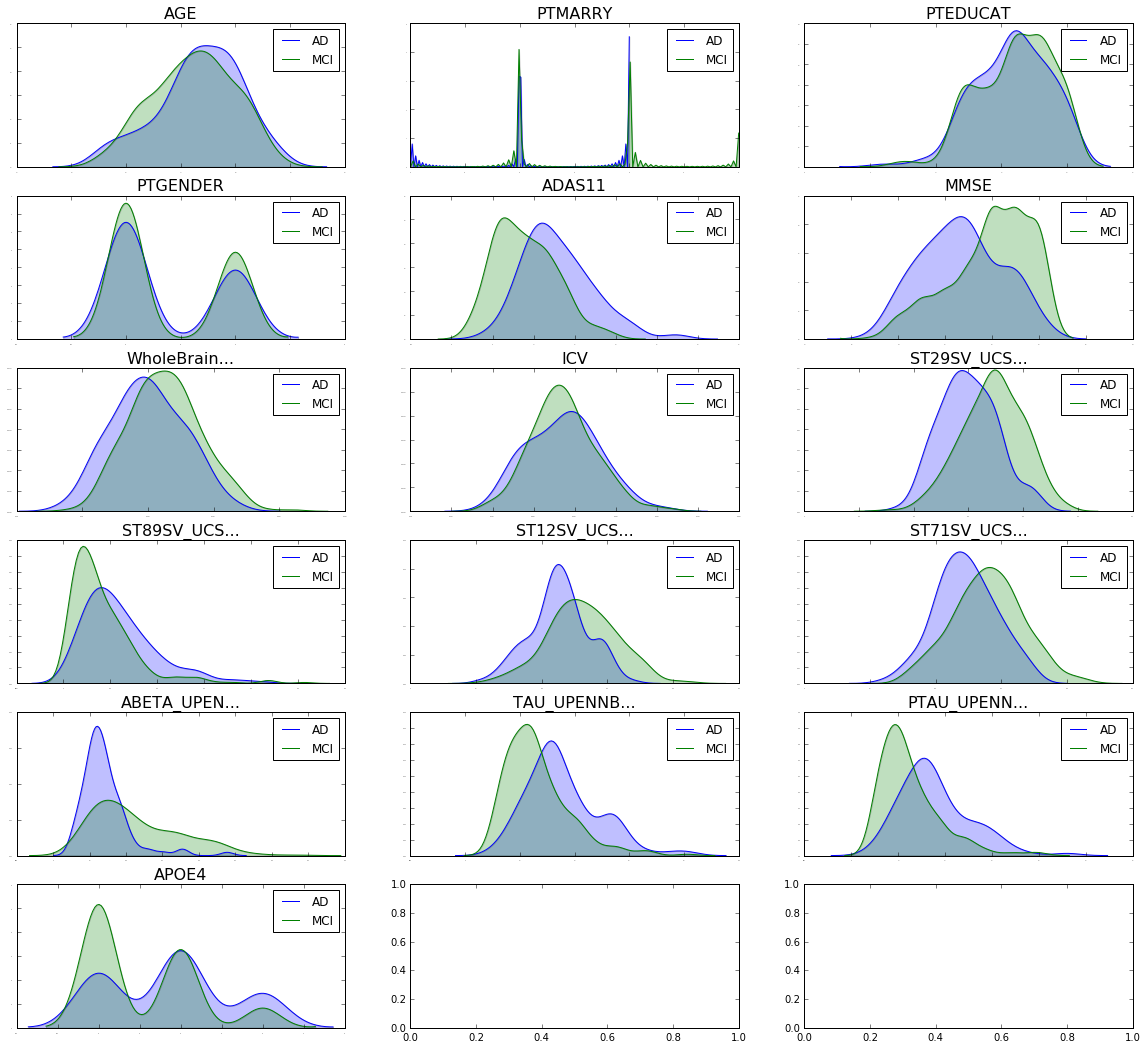

In [7]:
df_feature_selection = X_feature_selection.copy()
df_feature_selection["DX"] = y_feature_selection_str

names = list(df_feature_selection)[0:-1]
i_x = 6
i_y = 3
f,ax=plt.subplots(i_x,i_y,figsize=(20,18))
indice = 0
for name in names:
    gr = df_feature_selection.groupby("DX")
    gr = gr[name]
    i,j = indice/i_y,indice % i_y
    #print(" i : {}, j : {}".format(i,j))
    #print(name)
    for label, arr in gr:
        sns.kdeplot(arr, label=label, shade=True , ax = ax[i,j])
    ax[i,j].xaxis.set_tick_params(labelsize=0)
    ax[i,j].yaxis.set_tick_params(labelsize=0)
    L = len(name)
    if L < 10:
        ax[i,j].set_title(name,fontsize=16)
    else:
        ax[i,j].set_title(name[0:10] + "...",fontsize=16)
    indice += 1

There are 127 NaN  for __CSF__ (ABETA,TAU,PTAU) values out of a total of 498

It's a lot, but litterature says that ABETA,TAU and PTAU have a strong impact on Alzheimer diagnostic. Samples with NaN will be removed in a first approach, and the features kept.

To perform __feature selection__, XGBOOST method is used. It consists in training Gradient Boosted Trees to perform the classification of the label (AD/MCI) with all our features. Then, a score that tells the importance of each feature for the trees' training is given, so it's possible to see what are the most relevant features.

/home/lucsoret/Logiciels/anaconda3/envs/tensorflow/lib/python2.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


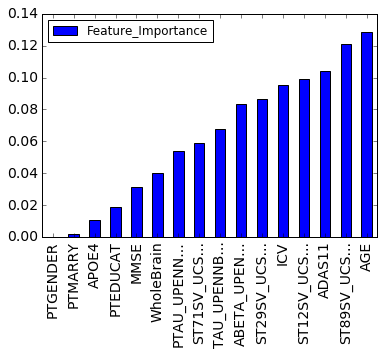

In [8]:
"""Remove NaN values for X_feature_selection"""

X_feature_selection = X_feature_selection.set_index(np.array(range(len(X_feature_selection.AGE.values))))
index_NaN = X_feature_selection["TAU_UPENNBIOMK9_04_19_17"].index[X_feature_selection["TAU_UPENNBIOMK9_04_19_17"].apply(np.isnan)]
X_feature_selection_CSF = X_feature_selection.dropna()

"""Remove the corresponding index for y_feature_selection"""
mask = np.ones(len(y_feature_selection), np.bool)
mask[index_NaN] = 0
y_feature_selection_CSF = y_feature_selection[mask]

X_feature_selection_CSF["PTAU_UPENNBIOMK9_04_19_17"] = pd.to_numeric(X_feature_selection_CSF.PTAU_UPENNBIOMK9_04_19_17)


"""
XGBOOST SELECTION
"""

# Fit model to training data
model = XGBClassifier()
model.fit(X_feature_selection_CSF, y_feature_selection_CSF)

names = list(X_feature_selection_CSF)
names_short = names

for i,name in enumerate(names):
    if len(name) > 10:
        names_short[i] = name[0:10] + "..."
feature_importance_df = pd.DataFrame(data= {"Feature_Importance": model.feature_importances_},index=names_short)
feature_importance_df.sort_values("Feature_Importance",inplace=True)
feature_importance_df.plot(kind="bar",fontsize = 14)

CSF values don't seem to be that relevant.

Thus samples with NaN for CSF values are kept, but those features are discarded

It's possible that the information in ADAS11 already contains the information in CSF values, explaining why they are not "that" relevant

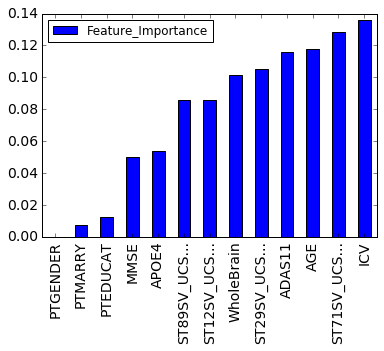

In [9]:
X_feature_selection_crop = X_feature_selection.drop(labels=["ABETA_UPENNBIOMK9_04_19_17","TAU_UPENNBIOMK9_04_19_17"
                                                      ,"PTAU_UPENNBIOMK9_04_19_17"],axis=1)
y_feature_selection_crop = y_feature_selection

"""
XGBOOST SELECTION
"""

# Fit model to training data
model = XGBClassifier()
model.fit(X_feature_selection_crop, y_feature_selection_crop)

names = list(X_feature_selection_crop)
names_short = names

for i,name in enumerate(names):
    if len(name) > 10:
        names_short[i] = name[0:10] + "..."
feature_importance_df = pd.DataFrame(data= {"Feature_Importance": model.feature_importances_},index=names_short)
feature_importance_df.sort_values("Feature_Importance",inplace=True)
feature_importance_df.plot(kind="bar",fontsize = 14)

For this dataset, it seems that *ICV*,*ST71SV...*,*AGE*,*ADAS11* are the most important features for this classification problem. Since there are only 499 samples, it's not a good idea to keep all the features. Indeed, the higher is the dimension, the higher is the risk of overfitting. That's why it's decided to only keep the 4 most relevant features for this classification problem

### Choice of the metric(s)

**<font color=green>What metric(s) are you going to use to evaluate your models performances ? Why ?</font>**

 This is a __classification__ problem, label being DX at M=24
 
 As it will be explained latter, after a bit of data preprocessing, we will have at M = 24 , a total of labels AD = 140 and MCI = 359. Thus, this dataset is a bit __unbalanced__
 
 That is to say, the number of True Negative is really high here comparatively to True Postive. That's why __Accuracy__ is not a good choice, and a score that doesn't count TN has to be selected
 
For our problem, False Positive detection (patient diagnostic to turn AD while in fact he's still MCI) and False Negative detection (patient diagnostic to stay MCI while he actually turned AD) are equally important. That is to say, __F1 score__ will be used, because it's the harmonic mean of Precision (aiming to minimize FP) and Recall (aiming to minimize FN)

### Choice of 2 models

Choose 2 models **of different nature** for the prediction.

**<font color=green>What models are you going to use ? What are the main differences betwen the two models and their respective strengths and weaknesses?</font>**

This is a case of __supervised learning__ for __classification__

The two models that will be used are : __Random Forests__ and __Support Vector Machine__

Random Forest consists in training a lot of Decision Trees (that individually overfit) and taking the mean of the result. This method is good in that it's fast to train a Random Forest, and to do prediction. Also, it computes statistics that can be usefull. However, this method is simple and is not efficient for complex cases, but it's good to use it as a first approach.

Support Vector Machine consists in separating the categories with a margin as wide as possible. For non-linear cases, kernel trick is used. This method is good in that it's efficient in high dimension and very flexible, thanks to Kernel Trick. However, it takes more computational time than RandomForest and doesn't give access to statistics. That's why it's good to use SVM when simpler method (such as Random Forests or Naive Bayes) are not efficient enough

### Data preparation, model training, optimisation and evaluation

Create, train and optimize your models. This should include the following steps :
- splitting the data into subsets you will need later on
- applying the preprocessing steps you consider useful to the data
- training and optimizing model 1 and model 2
- selecting the best model

Feel free to do these steps in the order you like, or to merge them if you think it is more convenient.

__Select input data__

In [10]:
"""Select the M = 0, DX = MCI, and the corresponding RID"""
X_classif = data.loc[(data["M"] == 0) & (data["DX"] == "MCI")]
RID_classif = X_classif.RID
"""Keep the relevant features"""
X_classif = pd.DataFrame(X_classif[["ICV","ADAS11","AGE",
                                  "ST71SV_UCSFFSX_11_02_15_UCSFFSX51_08_01_16"]])
"""From data, select the RID that correspond to the baseline"""
T = data[data.RID.isin(RID_classif)]
"""Select the corresponding M = 24"""
Y_classif = T.loc[T["M"] == 24]
"""y is only the DX label"""
y_classif_str = Y_classif.DX.values
"""Convert y_classif to int : 1 - AD, 0 - MCI"""
y_classif = [1 if y == "AD" else 0 for y in y_classif_str]

__Data Preprocessing__

In [11]:
"""There are no more categorical data, and X_classif data can then be normalized and centered"""
X_mean = X_classif.mean()
X_std = X_classif.std()

X_classif = (X_classif - X_mean)/X_std

__Visualize data : PCA to reduce dimension__

PCA is applied to our dataset to project our space into a 2-D space. 

Even if it not that clear, it seems that the problem is separable

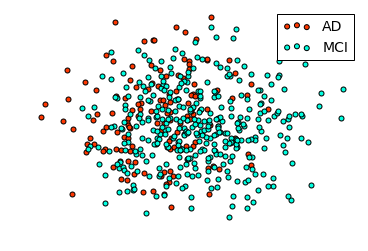

In [12]:
colors = ["#ff3801","#01ffe1"]

pca = PCA(n_components = 2)
pca.fit(X_classif)

projected = pca.fit_transform(X_classif)

x = projected[:,0]
y = projected[:,1]
classes = y_classif_str
unique = np.unique(classes)

for i, u in enumerate(unique):
    xi = [x[j] for j  in range(len(x)) if classes[j] == u]
    yi = [y[j] for j  in range(len(x)) if classes[j] == u]
    plt.scatter(xi, yi, c=colors[i], label=str(u),edgecolor=None,s = 25)

    plt.legend(fontsize = 14)
plt.axis('tight')
plt.axis('off')
plt.show()

__Split train and test data__

__NOTE : The values presented in my notes may differ with the results found after running the notebook. It's because Training and Test set are randomnly sampled each time, and there are not that much data__

In [13]:
X_classif_train, X_classif_test, y_classif_train, y_classif_test = train_test_split(X_classif,y_classif)

In [14]:
print(np.sum(y_classif_test))
print(len(y_classif_test))

36
125


__Random Forest classification__

In [15]:
rfc = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200,500,800],
    'max_depth' : [3,4,6,8]}

grid_RF = GridSearchCV(estimator=rfc,param_grid=param_grid, cv= 3)
grid_RF.fit(X_classif_train, y_classif_train)

print(grid_RF.best_params_)

model_RF = RandomForestClassifier(random_state=42, max_features='auto',
                                  n_estimators=grid_RF.best_params_["n_estimators"],
                                  max_depth = grid_RF.best_params_["max_depth"], criterion='gini')
model_RF.fit(X_classif_train,y_classif_train)


F1_RF_ovft = f1_score(y_classif_train,model_RF.predict(X_classif_train))
print("F1 Score for training data : {}".format(F1_RF_ovft.round(2)))
F1_RF = f1_score(y_classif_test,model_RF.predict(X_classif_test))
print("F1 Score for testing data : {}".format(F1_RF.round(2)))

{'n_estimators': 200, 'max_depth': 3}
F1 Score for training data : 0.49
F1 Score for testing data : 0.28


__SVM classification__

In [16]:
param_grid = {'C' : np.logspace(-3,3,20)}

grid_SVM = GridSearchCV(SVC(kernel = 'rbf',gamma = 'auto'),param_grid, cv = 3)
grid_SVM.fit(X_classif_train,y_classif_train)

model_SVM = SVC(kernel = "rbf", C = grid_SVM.best_params_['C'], gamma = 'auto')
model_SVM.fit(X_classif_train,y_classif_train)

F1_SVM = f1_score(y_classif_test,model_SVM.predict(X_classif_test))
F1_SVM_ovft = f1_score(y_classif_train,model_SVM.predict(X_classif_train))


print(grid_SVM.best_params_)
print("F1 Score for training data : {}".format(F1_SVM_ovft.round(2)))
print("F1 Score for testing data : {}".format(F1_SVM.round(2)))

{'C': 2.9763514416313162}
F1 Score for training data : 0.5
F1 Score for testing data : 0.34


/home/lucsoret/Logiciels/anaconda3/envs/tensorflow/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


__Confusion Matrix__

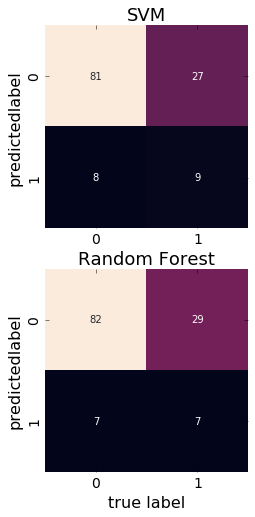

In [17]:
f,ax=plt.subplots(2,1,figsize=(12,8))

mat_SVM = confusion_matrix(y_classif_test,model_SVM.predict(X_classif_test))
mat_RF = confusion_matrix(y_classif_test,model_RF.predict(X_classif_test))

for i,a in enumerate(ax):
    if i == 0:
        sns.heatmap(mat_SVM.T, square=True, annot=True, fmt='d', cbar=False,ax=a)
        a.set_title("SVM",fontsize=18)
    else:
        sns.heatmap(mat_RF.T, square=True, annot=True, fmt='d', cbar=False,ax=a)
        a.set_title("Random Forest",fontsize=18)
        a.set_xlabel("true label",fontsize=16)
    a.set_ylabel("predictedlabel",fontsize=16)
    a.tick_params(axis='both', which='major', labelsize=14)

### Analysis

**<font color=green>Explain briefly what you think of your best model's performances. Would you use it as such ?</font>**

* For RM forest, there is (may differ when test is re-run) : a F1 score of 0.28 for testing data and 0.49 for training data
* For SVM, there is (may differ when test is re-run) : a F1 score of 0.34.for testing data and 0.50 for training data

Both models seem to have similar (and bad) results, even if SVM is slighlty better.

An estimator that labels everything as positive will have a Precision of 36/125 and a Recall of 1, giving a F1 Score of 0.44, so our models are not reliable

The high difference between F1 score for training and testing data, and the huge variation of the results for each run is explained by the small size of the dataset. It's requiered to have more data in order to have satisfaying results. That's why for now, those models can't be used as such

### Further improvements


**<font color=green>If you had more time / more resources, what would you do to improve your model ?</font>**

In my opinion, the best improvement that can be done here is to increase the dataset size. The fact that scores change a lot from a test to an other, and the difference between F1 score on test and training set is I think mainly due to the small dataset size. This could also lead to use more features to perform the classification, without overfitting

Also, having values for CSF data may improve the separability of the data

And, a GridSearch with more parameters will obvioulsy lead to a better result

## 3 - Prediction of the ADAS11 score

In this section, you may use all the patients. Remember that only the data from baseline (i.e. M=0) can be used as inputs to your models.

### Exploratory data analysis

**<font color=green>Which features seem to have an impact on the ADAS11 variable at M=24 ? Describe your methodological choices and illustrate your answer with a few relevant graphs.</font>**


Gradient Boosting Tree for Regression are used here, to sort the features by their importance on regression to ADAS11

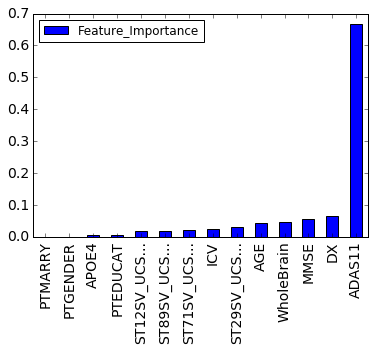

In [18]:
"""GBDT for Feature Selection"""
I = data.loc[data["M"] == 0]


"""Handle X"""

"""CSF labels are dropped, along with Month and RID"""
X_feature_selection = I.drop(labels = ["M","RID",'ABETA_UPENNBIOMK9_04_19_17','TAU_UPENNBIOMK9_04_19_17',
                               'PTAU_UPENNBIOMK9_04_19_17'] , axis = 1)

X_feature_selection_DX = I.DX.values
X_feature_selection_DX = [1 if x == "AD" else 0 for x in X_feature_selection_DX]
X_feature_selection["DX"] = X_feature_selection_DX

"""Handle y"""
y_feature_selection = data.loc[data["M"] == 24].ADAS11.values

# Fit model to training data
model = GradientBoostingRegressor()
model.fit(X_feature_selection, y_feature_selection)

names = list(X_feature_selection)
names_short = names

for i,name in enumerate(names):
    if len(name) > 10:
        names_short[i] = name[0:10] + "..."
feature_importance_df = pd.DataFrame(data= {"Feature_Importance": model.feature_importances_},index=names_short)
feature_importance_df.sort_values("Feature_Importance",inplace=True)
feature_importance_df.plot(kind="bar",fontsize = 14)

*ADAS11* at M = 0 is by far the most important feature, which makes sense because the regression is about the same feature but at M = 24

There is a correlation of 0.79 between ADAS11 at M=0 and ADAS11 at M= 24 : the relation is strongly linear


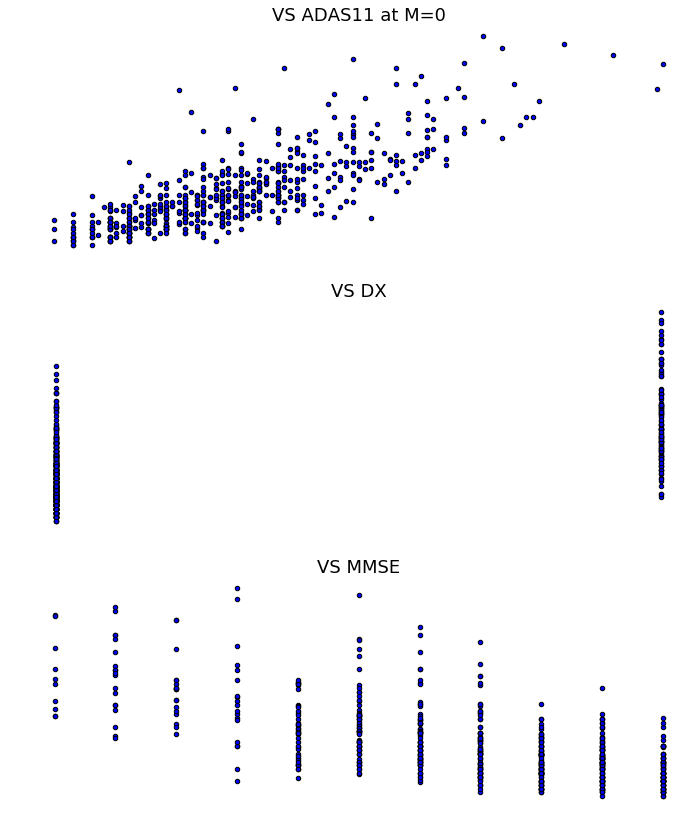

In [19]:
f,ax=plt.subplots(3,1,figsize=(12,14))

ax[0].scatter(X_feature_selection["ADAS11"],y_feature_selection)
ax[1].scatter(X_feature_selection["DX"],y_feature_selection)
ax[2].scatter(X_feature_selection["MMSE"],y_feature_selection)

for a in ax:
    a.axis('tight')
    a.axis('off')
ax[0].set_title("VS ADAS11 at M=0",fontsize=18)
ax[1].set_title("VS DX",fontsize=18)
ax[2].set_title("VS MMSE",fontsize=18)

print("There is a correlation of {} between ADAS11 at M=0 and ADAS11 at M= 24 : the relation is strongly linear").format(np.corrcoef(X_feature_selection["ADAS11"],y_feature_selection)[0,1].round(2))

### Choice of the metric(s)

**<font color=green>What metric(s) are you going to use to evaluate your models performances ? Why ?</font>**

This is a __regression__ problem

Thus, a classic __ Root Mean Square Error__ is a good choice



### Choice of 2 models

Choose 2 models **of different nature** for the prediction.

**<font color=green>What models are you going to use ? What are the main differences betwen the two models and their respective strengths and weaknesses?</font>**

There is a huge correlation between ADAS11 for M = 0 and M = 24. Thus, two different methods will be prefered :

In the previous exemple, SVM was the best model, and SVM for Regression is used here. This model has same strenghts and weaknesses as SVM for classification.

However, instead of Random Forest, a very simple Linear Regression will be performed. This model is simple, fast to compute and easy to understand

### Data preparation, model training, optimisation and evaluation

Create, train and optimize your models. This should include the following steps :
- splitting the data into subsets you will need later on
- applying the preprocessing steps you consider useful to the data
- training and optimizing model 1 and model 2
- selecting the best model

Feel free to do these steps in the order you like, or to merge them if you think it is more convenient.

__Selecting data__

In [20]:
"""Select Month for Input and Output"""
X_regr = data.loc[data["M"] == 0]
Y_regr = data.loc[data["M"] == 24]

"""Output is just ADAS11 score"""
y_regr = Y_regr.ADAS11
"""DX being a categorical data, Z-score can't be used"""
X_regr_DX_str = X_regr.DX.values
"""Only keep the most relevant data"""
X_regr = pd.DataFrame(X_regr[["ADAS11","MMSE"]])
"""DX is converted to numerical data"""
X_regr_DX = [1 if x == "AD" else 0 for x in X_regr_DX_str]
"""There are no more categorical data, and X_classif data can then be normalized and centered"""
X_mean = X_regr.mean()
X_std = X_regr.std()
X_regr = (X_regr - X_mean)/X_std
"""y_regr is also normalized and centered"""
y_mean = y_regr.mean()
y_std = y_regr.std()
y_regr = (y_regr - y_mean)/y_std
"""Add DX column"""
X_regr["DX"] = X_regr_DX

__Split train test__

In [21]:
X_regr_train, X_regr_test, y_regr_train, y_regr_test = train_test_split(X_regr,y_regr)

__SVM__

In [22]:
param_grid = {'C' : np.logspace(-2,2,10),'kernel' : ['rbf','linear'],'epsilon' : np.logspace(-2,1,10) }

grid_SVM = GridSearchCV(SVR(gamma = 'auto'),param_grid, cv = 3)
grid_SVM.fit(X_classif_train,y_classif_train)

model_SVM = SVR(kernel = grid_SVM.best_params_['kernel'], C = grid_SVM.best_params_['C'],
                epsilon = grid_SVM.best_params_["epsilon"], gamma = 'auto')
model_SVM.fit(X_regr_train,y_regr_train)

RMSE_SVM_ovft = mean_squared_error(y_regr_train,model_SVM.predict(X_regr_train))
RMSE_SVM = mean_squared_error(y_regr_test,model_SVM.predict(X_regr_test))

print(grid_SVM.best_params_)
print("RMSE for training data : {}".format(np.sqrt(RMSE_SVM_ovft).round(2)))
print("RMSE for testing data : {}".format(np.sqrt(RMSE_SVM.round(2))))

{'epsilon': 0.21544346900318834, 'C': 0.21544346900318834, 'kernel': 'rbf'}
RMSE for training data : 0.6
RMSE for testing data : 0.616441400297


/home/lucsoret/Logiciels/anaconda3/envs/tensorflow/lib/python2.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


__Linear Regression__

A linear regression can't overfit, but data are still splitted between Training and Testing data so that it's possible to compare the two models

In [23]:
model_LR = LinearRegression(fit_intercept=True)
model_LR.fit(X_regr_train,y_regr_train)

MSE_LR_ovft = mean_squared_error(y_regr_train,model_LR.predict(X_regr_train))
print("RMSE for training data : {}".format(np.sqrt(MSE_LR_ovft).round(2)))
MSE_LR = mean_squared_error(y_regr_test,model_LR.predict(X_regr_test))
print("RMSE Score for testing data : {}".format(np.sqrt(MSE_LR).round(2)))

RMSE for training data : 0.56
RMSE Score for testing data : 0.59


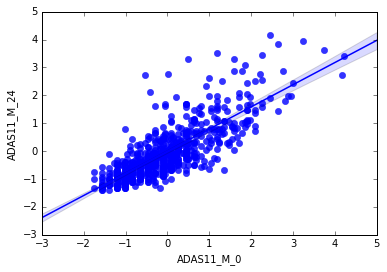

In [24]:
df_plot = pd.DataFrame({'ADAS11_M_0' : X_regr["ADAS11"].values , 'ADAS11_M_24' : y_regr})
sns.regplot(x = 'ADAS11_M_0', y = 'ADAS11_M_24', data=df_plot,scatter_kws = {'s' : 40})

In [27]:
model_LR_total = LinearRegression(fit_intercept=True)
model_LR_total.fit(X_regr,y_regr)


MSE_LR_total = mean_squared_error(y_regr,model_LR_total.predict(X_regr))
print("RMSE for training data : {}".format(np.sqrt(MSE_LR_total).round(2)))

RMSE for training data : 0.57


### Analysis

**<font color=green>Explain briefly what you think of your best model's performances. Would you use it as such ?</font>**

Linear Regression is a bit more accurate than SVM, and  faster to compute. It's understable in that there is a strong linear relantionship between *ADAS11_M_0* and *ADAS11_M_24* (correlation of 0.79).

For the testing test, *RMSE* is arround 0.60, and for the whole set *RMSE* = 0.57, the standard deviation for ADAS11 at M = 24 (after Z-scoring) being arround 1.0, one can assume that the regression performed is good, but not good enough to be used in a clinical context.

### Further improvements


**<font color=green>If you had more time / more resources, what would you do to improve your model ?</font>**

With available data, it's not really possible to really improve our regression. Indeed, ADAMS11 explains almost all the variance of the target feature, and the relationship is close to be linear. It's not possible to find a model that performs slighlty better than a Linear Regression. However, collecting more data or maybe other features (such as a third appointment), could lead to an improvement of the regression.